In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
config = project.core.fileio.load_config('2026-01-15_config.yaml')
config

Loading 2026-01-15_config.yaml


{'dataset': {'name': 'ShapeNet',
  'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
  'examples': {'subjects': 'subjects.csv', 'variant': '2026-01-15'},
  'metadata': {'parse_metadata': True,
   'unit_policy': 'prefer_metadata',
   'default_unit': 0.01},
  'selectors': {'input_image': 'uniform2'}},
 'preprocessing': {'binary_mask': {'foreground_filter': {'max_components': 1,
    'keep_largest': True},
   'background_filter': {'min_voxels': 30},
   'center_mask': True,
   'pad_amount': 0.37},
  'surface_mesh': {'run_pymeshfix': True},
  'region_mask': {'label_method': 'nearby_faces',
   'region_filter': {'min_voxels': 1000, 'keep_largest': False}},
  'volume_mesh': {'use_affine_spacing': False,
   'meshing_parameters': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'material_mask': {'material_catalog': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-15_materials.csv',
   'mat

In [4]:
%autoreload
# example selection
# wss.1f5c74f0a55cbf9798d5fc0473d00a1c - nan with 1e-5 reg weight
# wss.1e5abf0465d97d826118a17db9de8c0 - vase

data_config = config['dataset'].copy()
data_config['root'] = '../../data/ShapeNetSem'
data_config['examples']['subjects'] = '../../subjects.csv'

ex = project.api.get_examples(data_config)[0]
pprint(ex, max_depth=1)

Gathering examples
Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.100f39dce7690f59efb94709f30ce0d2'
├── variant:  '2026-01-15'
├── paths:    dict(len=13)
└── metadata: dict(len=4)


In [5]:
# start optimize_example()
optim_config = config['optimization'].copy()

inputs = project.datasets.torch.TorchDataset([ex])[0]
image  = inputs['image']
mask   = inputs['mask']
E_true_vox = inputs['elast']
affine = inputs['affine']
mesh   = inputs['mesh']
unit_m = float(ex.metadata['unit'])

Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_material_uniform2.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_material_uniform2_tetmesh_mat_int.xdmf
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_elastic.nii.gz


In [6]:
import project.physics
physics_adapter_kws = optim_config.get('physics_adapter', {})
pde_solver_kws = optim_config.get('pde_solver', {}).copy()

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_kws.pop('_class'),
    pde_solver_kws=pde_solver_kws,
    **physics_adapter_kws
)

In [7]:
import project.models
param_kws = optim_config.get('parameters', {}).copy()
init_value = param_kws.pop('init_value')
param_map = project.models.ParameterMap(**param_kws)
param = physics_adapter.init_param_field(mesh, unit_m, init_value)

In [8]:
shape = E_true_vox.shape[1:]
shape

torch.Size([224, 224, 224])

In [9]:
affine

tensor([[  0.6719,   0.0000,   0.0000, 125.7739],
        [  0.0000,   0.6719,   0.0000, -23.7247],
        [  0.0000,   0.0000,   0.6719, -51.3985],
        [  0.0000,   0.0000,   0.0000,   1.0000]])

In [10]:
affine.device, affine.dtype

(device(type='cpu'), torch.float32)

In [11]:
unit_m

0.0129471722278774

In [12]:
import sys, platform
import torch
import warp as wp
import warp.fem
wp.init()

print('System:', platform.platform())
print('Python version:', sys.version)
print('Pytorch version:', torch.__version__)
print('Warp version:', wp.__version__)

def test_interpolate(device1, device2, grid_size=4, bg=0.):

    # source geometry initialized on device 1
    verts = torch.tensor([
        [0.,0.,0.], # 0
        [1.,0.,0.], # 1
        [0.,1.,0.], # 2
        [1.,1.,0.], # 3
        [0.,0.,1.], # 4
        [1.,0.,1.], # 5
        [0.,1.,1.], # 6
        [1.,1.,1.], # 7
    ], dtype=torch.float32, device=device1)
    
    cells = torch.tensor([
        [0,1,3,7],
        [0,3,2,7],
        [0,2,6,7],
        [0,6,4,7],
        [0,4,5,7],
    ], dtype=torch.int32, device=device1)

    with wp.ScopedDevice(device2):

        src_geom = wp.fem.Tetmesh(
            wp.from_torch(cells, dtype=wp.int32),
            wp.from_torch(verts, dtype=wp.vec3f),
            build_bvh=True
        )
        # from_torch doesn't copy to device2 (expected)
        assert src_geom.positions.device == device1

        src_space = wp.fem.make_polynomial_space(src_geom, degree=0, dtype=wp.float32)
        src_field = src_space.make_field()
        
        wp.copy(src_field.dof_values, wp.ones(5))
        
        dst_geom = wp.fem.Grid3D(
            res=wp.vec3i(grid_size,grid_size,grid_size),
            bounds_lo=wp.vec3f(0,0,0),
            bounds_hi=wp.vec3f(1,1,1)
        )
        dst_domain = wp.fem.Cells(dst_geom)
        dst_space = wp.fem.make_polynomial_space(dst_geom, degree=0, dtype=wp.float32)
        dst_field = dst_space.make_field()
        
        src_nc = wp.fem.NonconformingField(dst_domain, src_field, background=bg)
        wp.fem.interpolate(src_nc, dest=dst_field)

        src_tensor = wp.to_torch(dst_field.dof_values)
        mean_value = torch.mean(src_tensor).item()
    
        print(device1, device2, mean_value)

        if device1 != device2:
            assert mean_value == bg
        else:
            assert mean_value != bg

test_interpolate('cpu', 'cpu')   # 0.9375
test_interpolate('cuda', 'cuda') # 0.9375
test_interpolate('cpu', 'cuda')  # 0.0
test_interpolate('cuda', 'cpu')  # 0.0

System: Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28
Python version: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Pytorch version: 2.4.0
Warp version: 1.10.0.dev20251007
cpu cpu 0.9375
cuda cuda 0.9375
cpu cuda 0.0
cuda cpu 0.0


In [13]:
%autoreload

ctx = physics_adapter.get_context(mesh, unit_m)
E_true_dofs = ctx.E[physics_adapter.scalar_degree]

E_true_raster = physics_adapter.rasterize_scalar_field(
    mesh, unit_m, E_true_dofs, E_true_vox.shape[1:], affine
)
E_true_raster.mean()

tensor(528.8887)

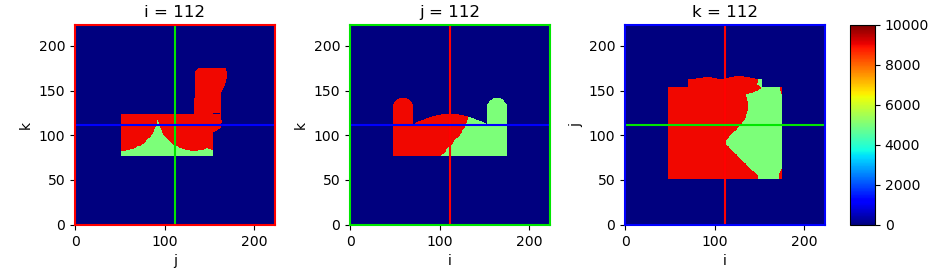

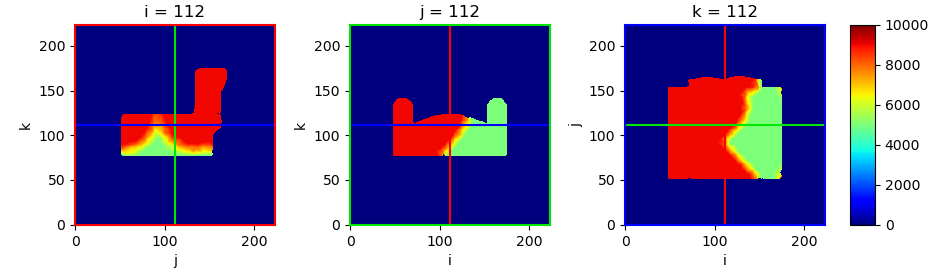

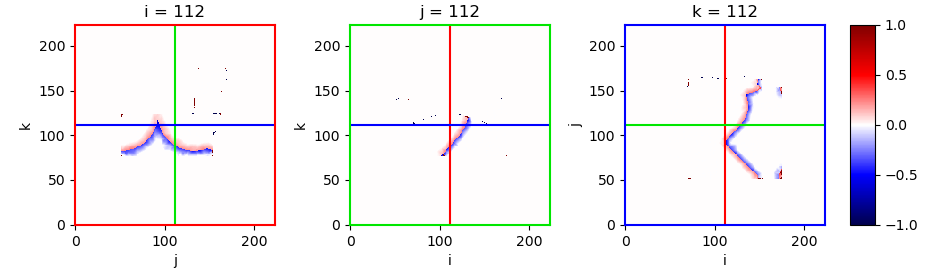

In [14]:
import project.visual
_ = project.visual.matplotlib.show_image_slices(E_true_vox[0].detach().cpu().numpy(), cmap='jet', clim=(0,1e4))
_ = project.visual.matplotlib.show_image_slices(E_true_raster[0].detach().cpu().numpy(), cmap='jet', clim=(0,1e4))

error = ((E_true_vox - E_true_raster) / (E_true_vox + 1e-6))
_ = project.visual.matplotlib.show_image_slices(error[0].detach().cpu().numpy(), cmap='seismic', clim=(-1,1))

Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_material_uniform2.nii.gz


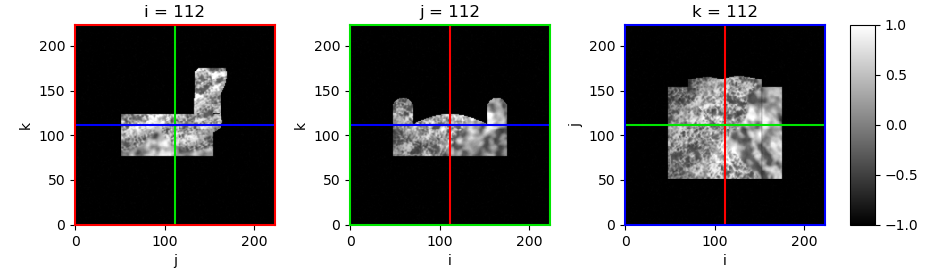

In [15]:
nifti = project.core.fileio.load_nibabel(ex.paths['input_image'])
image = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(image - 1.0, cmap='gray', clim=(-1,1))

In [16]:
outputs = project.api.RunOutputs(stage='optimize')
output_path = outputs.mesh_path(ex, 'optimized')
raster_path = outputs.nifti_path(ex, 'optimized')

In [17]:
optim_config

{'parameters': {'init_value': 3.4863,
  'param_space': 'log',
  'bounds_mode': 'soft',
  'lower_bound': 1.0,
  'upper_bound': 6.0},
 'physics_adapter': {'nu_value': 0.4,
  'rho_bias': 1000,
  'rho_known': True,
  'scalar_degree': 1,
  'vector_degree': 1},
 'pde_solver': {'_class': 'WarpFEMSolver', 'tv_reg_weight': 0.0001},
 'optimizer': {'_class': 'LBFGS',
  'lr': 1.0,
  'max_iter': 100,
  'history_size': 10,
  'line_search_fn': 'strong_wolfe'}}

In [23]:
%autoreload
import project.optimization

metrics = project.optimization.optimize_example(ex, optim_config, output_path, raster_path)
metrics

Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_material_uniform2.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_material_uniform2_tetmesh_mat_int.xdmf
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_elastic.nii.gz
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	1.7701e+00 (nan)	1.1251e-08 (1.0000e+00)	3.2517e+02 (nan)
1	5.7741e-02 (9.6738e-01)	1.1207e-08 (9.9607e-01)	3.2517e+02 (0.0000e+00)
Optimization converged
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	5.7741e-02 (nan)	3.9105e-05 (1.0000e+00)	3.2645e+02 (nan)
1	5.3418e-05 (9.9907e-01)	3.3795e-05 (8.6420e-01)	3.2649e+02 (0.0000e+00)
Optimization converged
dict(len=9)
├── 'volume':   Tensor(shape=torch.Size([31485]), dtype

In [27]:
mesh = project.core.fileio.load_meshio(output_path)
pv_mesh = pv.wrap(mesh)
pv_mesh

Loading outputs/optimize/wss.100f39dce7690f59efb94709f30ce0d2/meshes/optimized.xdmf


UnstructuredGrid (0x1536eeeefdc0)
  N Cells:    31485
  N Points:   7115
  X Bounds:   1.577e+02, 2.437e+02
  Y Bounds:   1.084e+01, 9.014e+01
  Z Bounds:   -4.355e-02, 6.656e+01
  N Arrays:   24

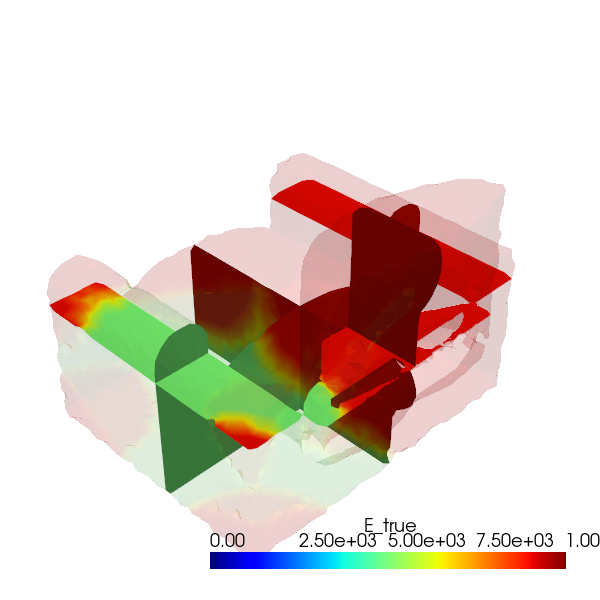

In [28]:
size = 600
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_true', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_true', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

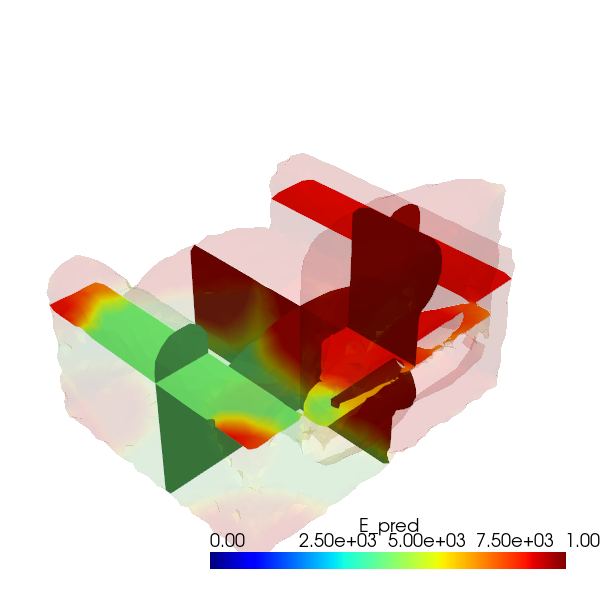

In [29]:
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_pred', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_pred', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_elastic.nii.gz
Loading outputs/optimize/wss.100f39dce7690f59efb94709f30ce0d2/niftis/optimized.nii.gz


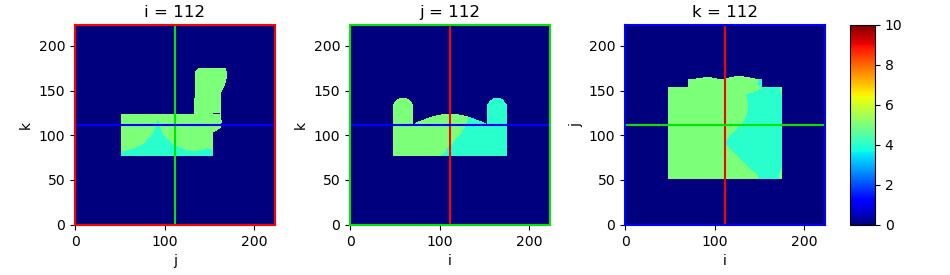

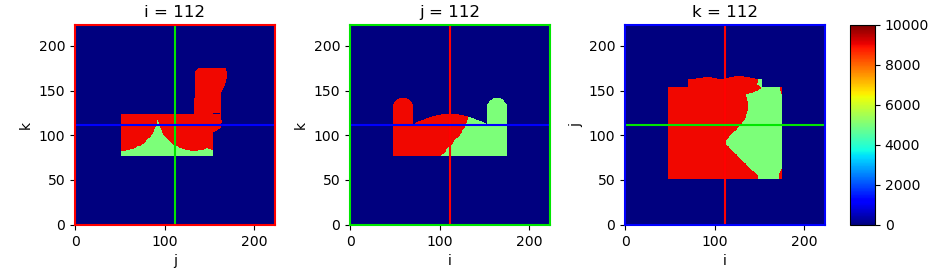

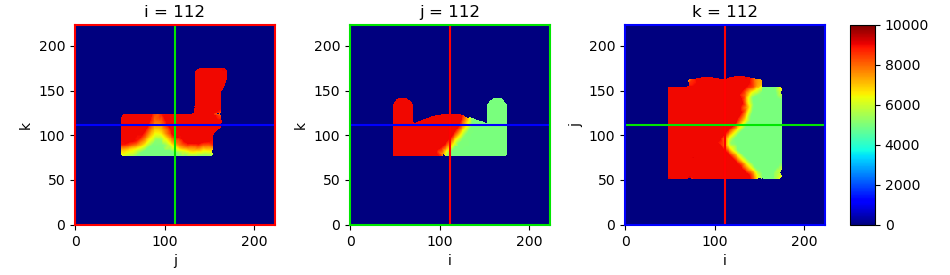

In [30]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['material_mask'])
mask = nifti.get_fdata().astype(int)
_ = project.visual.matplotlib.show_image_slices(mask, cmap='jet', clim=(0, 10))

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
E_true = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_true, cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(raster_path)
E_pred = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_pred, cmap='jet', clim=(0, 1e4))

In [42]:
pd.read_csv('outputs/example_metrics.csv')

,epoch,phase,batch,step,loss,subject,num_voxels,E_vox.mean,E_vox.rms,E_vox.rmse,...,E_cell.scorr,u_cell.mean,u_cell.rms,u_cell.rmse,u_cell.nrmse,u_cell.srmse,u_cell.pcorr,u_cell.scorr,res_cell.mean,res_cell.rms
0,0,optimize,0,0,0.000051,wss.100f39dce7690f59efb94709f30ce0d2,778627,7591.852874,7817.06595,764.623532,...,0.82281,0.006504,0.007865,0.000008,0.001068,0.001899,0.999999,0.999979,0.434869,0.805458


In [44]:
pd.read_csv('outputs/material_metrics.csv')['mat_vox.dice']

0    0.975979
1    0.987764
Name: mat_vox.dice, dtype: float64

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)